# Reading and cleaning the DonorsChoose project data
In this notebook, we read the DonorsChoose project data (downloaded from https://s3.amazonaws.com/open_data/csv/opendata_projects.zip).

In [1]:
import pandas as pd

DonorsChooseDataHead = pd.read_csv('../../data/opendata_projects.csv', nrows = 6)

The first thing we need to do is identify features to extract from this data set. Let's look at the columns:

In [2]:
DonorsChooseDataHead.columns

Index([u'_projectid', u'_teacher_acctid', u'_schoolid', u'school_ncesid',
       u'school_latitude', u'school_longitude', u'school_city',
       u'school_state', u'school_zip', u'school_metro', u'school_district',
       u'school_county', u'school_charter', u'school_magnet',
       u'school_year_round', u'school_nlns', u'school_kipp',
       u'school_charter_ready_promise', u'teacher_prefix',
       u'teacher_teach_for_america', u'teacher_ny_teaching_fellow',
       u'primary_focus_subject', u'primary_focus_area',
       u'secondary_focus_subject', u'secondary_focus_area', u'resource_type',
       u'poverty_level', u'grade_level', u'vendor_shipping_charges',
       u'sales_tax', u'payment_processing_charges',
       u'fulfillment_labor_materials',
       u'total_price_excluding_optional_support',
       u'total_price_including_optional_support', u'students_reached',
       u'total_donations', u'num_donors', u'eligible_double_your_impact_match',
       u'eligible_almost_home_match', u'f

The features we want are:
 - _teacher_acctid: (so we can count the number of unique teachers requesting grants from DonorsChoose in a school)
 - school_ncesid: (so we can merge the DonorsChoose data with our SCHMA and expenditure data)
 - resource_type: Books, Technology, Supplies, Trips, Visitors, Other (since we ultimately want to extract only supply, books, and technology requests).
 - total_price_including_optional_support: (this is the total cost of the grant request, excluding an optional donation to DonorsChoose to cover the non-profit's overhead).
 - funding_status: (since we only want to extract completed projects).
 - date_completed: (since we only want projects completed for the 2005-2006 AY through 2011-2012 AY).

Now that we've identified the feature's we're interested in, let's read in the entire dataset.

In [3]:
DonorsChooseAllData = pd.read_csv('../../data/opendata_projects.csv', usecols = ['_teacher_acctid', 'school_ncesid', 'resource_type', 'total_price_excluding_optional_support', 'funding_status', 'date_completed'])

In [4]:
DonorsChooseAllData.shape

(878852, 6)

Now let's start cleaning the data. First, let's drop all projects that were not completed (i.e. funds were not awarded for the project).

In [5]:
DonorsChooseAllData.funding_status.value_counts()

completed      592757
expired        253407
live            24559
reallocated      8129
dtype: int64

In [6]:
DonorsChooseAllData = DonorsChooseAllData[DonorsChooseAllData['funding_status'] == 'completed']
DonorsChooseAllData.funding_status.value_counts()

completed    592757
dtype: int64

Next, let's drop all projects that were not for supplies and technology.

In [7]:
DonorsChooseAllData.resource_type.value_counts()

Supplies      213331
Technology    174092
Books         133556
Other          63817
Trips           6880
Visitors        1051
dtype: int64

In [8]:
DonorsChooseAllData = DonorsChooseAllData[DonorsChooseAllData['resource_type'].isin(['Supplies','Technology','Books'])]
DonorsChooseAllData.resource_type.value_counts()

Supplies      213331
Technology    174092
Books         133556
dtype: int64

Next, let's see how many records are missing values:

In [9]:
null = DonorsChooseAllData.isnull().any(axis=1).sum()
print 'There are', null, 'rows with missing values'

There are 30057 rows with missing values


Let's see which fields are missing values:

In [12]:
DonorsChooseAllData.count()

_teacher_acctid                           520979
school_ncesid                             490922
resource_type                             520979
total_price_excluding_optional_support    520979
funding_status                            520979
date_completed                            520979
dtype: int64

All the missing values are in the school_ncesid field. Since this feature is our merge key, these values will be dropped regardless- thus, we drop them now.

In [13]:
DonorsChooseAllData.dropna(how='any', inplace=True)
DonorsChooseAllData.shape

(490922, 6)

Next, we need to read in the NCES ID's we have for our NYC Schools. We will then use these values as a filter (using .isin) to select only projects for schools in our NYC Schools dataset. 

In [14]:
NCES_IDs = pd.read_csv('NCES_IDS_NYC.csv', header=None, names=['index', 'NCES_ID'], usecols=['NCES_ID'])
NCES_IDs = NCES_IDs.astype(int)

In [15]:
NCES_IDs.shape

(1252, 1)

Now we filter our project data using these NCES_IDs. First, we change DonorsChooseAllData.school_ncesid to an int type feature.

In [16]:
DonorsChooseAllData['school_ncesid'] = DonorsChooseAllData['school_ncesid'].astype(int)

In [17]:
DonorsChooseAllData = DonorsChooseAllData[DonorsChooseAllData['school_ncesid'].isin(NCES_IDs["NCES_ID"])]
DonorsChooseAllData.shape

(29882, 6)

Next, we use the "Date_completed" feature to construct a new feature, Year, which corresponds to the academic year. For this purpose, we are use June 1 through May 31st as the academic year (date_completed is the date the project was fully funded- since additional time is needed for procurement and shipping, we are justified in making June 1st the cutoff for the academic year).

In [18]:
import numpy as np

def bin_datetime(date):
    for year in range(2006,2013):
        start = str(year-1) + '-6-01'
        end = str(year) + '-5-31'
        academic_year = pd.date_range(start,end)
        if date in academic_year:
            return year
    return np.NaN

def add_year_feature():
    DonorsChooseAllData.date_completed = DonorsChooseAllData.date_completed.map(lambda x: pd.to_datetime(x))
    DonorsChooseAllData['Year'] = DonorsChooseAllData.date_completed.map(bin_datetime)
    return DonorsChooseAllData

DonorsChooseAllData = add_year_feature()

In [19]:
DonorsChooseAllData.dropna(axis=0, how='any', inplace=True)

In [20]:
DonorsChooseAllData.Year.value_counts()

2011    3732
2010    3591
2012    2970
2009    2494
2008    1744
2007    1380
2006    1329
dtype: int64

In [21]:
DonorsChooseAllData.head(6)

,_teacher_acctid,school_ncesid,resource_type,total_price_excluding_optional_support,funding_status,date_completed,Year
2960,8693409bfb567e832a344fe89957a34f,360008604459,Supplies,387.45,completed,2006-05-05,2006
4237,950ec91d97df2c5449ddcbc002582ae3,360011904358,Technology,834.00,completed,2005-06-24,2006
4447,80bdae0b3cc642138de2fd05e421b000,360015304885,Technology,559.00,completed,2006-08-29,2007
4561,7a20087fac86232883537cab45c0a6c9,360012202592,Books,540.00,completed,2005-06-06,2006
4562,7a20087fac86232883537cab45c0a6c9,360012202592,Books,252.00,completed,2005-06-24,2006
4606,93e409fe9b447635f9b3859ce577b80e,360012104886,Supplies,210.00,completed,2005-12-17,2006


Next, since we want records by school/year, we need to group and aggregate:

In [22]:
grouped = DonorsChooseAllData.groupby(['school_ncesid','Year']).aggregate({'total_price_excluding_optional_support': np.sum,
                                                                           '_teacher_acctid': lambda x: x.nunique(),
                                                                          'funding_status': lambda x: len(x)})
grouped.head(3)

funding_status  total_price_excluding_optional_support  \
school_ncesid Year                                                           
360007600624  2006               2                                 2186.00   
              2010               1                                  343.02   
              2011               1                                  477.14   

                    _teacher_acctid  
school_ncesid Year                   
360007600624  2006                1  
              2010                1  
              2011                1

In [33]:
grouped.columns = ['Number_projects','Total_donations_recieved','Number_teachers_participating']
grouped.head(3)

Number_projects  Total_donations_recieved  \
school_ncesid Year                                              
360007600624  2006                2                   2186.00   
              2010                1                    343.02   
              2011                1                    477.14   

                    Number_teachers_participating  
school_ncesid Year                                 
360007600624  2006                              1  
              2010                              1  
              2011                              1

Now, let's briefly explore this dataset:

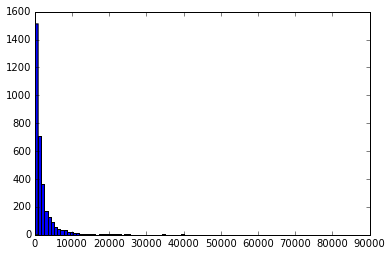

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
donation_vals = plt.hist(grouped.Total_donations_recieved.values, bins=100)

In [28]:
total_funds = {}
for year in range(2006,2013):
    total_funds[year] = grouped.loc[(slice(None),year),'Total_donations_recieved'].sum()
print total_funds

{2006: 581719.17, 2007: 763564.300000001, 2008: 814871.1700000003, 2009: 1082817.73, 2010: 1848215.0999999992, 2011: 1659365.6900000004, 2012: 1260168.7700000014}


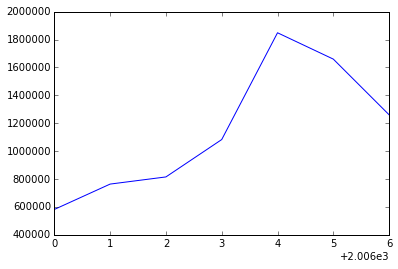

In [29]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(total_funds.keys(), total_funds.values())
plt.show(fig)

In [31]:
total_teachers = {}
for year in range(2006,2013):
    total_teachers[year] = grouped.loc[(slice(None),year),'Number_teachers_participating'].sum()
print total_teachers

{2006: 684, 2007: 708, 2008: 1002, 2009: 1341, 2010: 1644, 2011: 1708, 2012: 1387}


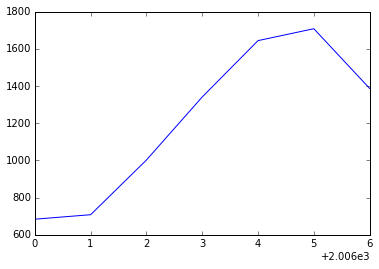

In [32]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(total_teachers.keys(), total_teachers.values())
plt.show(fig)

Interestingly, it is apparent that the number of participating teachers (and amount of money requested) clearly rose and fell during the recession.

Now let's write this dataframe to csv so we can merge it with the cleaned_SCHMA data.

In [34]:
grouped.to_csv('../../data/clean_donors_choose.csv')